In [2]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
print('imported numpy and astropy', flush=True)
from galpy.df import streamdf
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import conversion #for unit conversions
from galpy.util.conversion import get_physical
print('imported galpy', flush=True)
from galpy.potential.mwpotentials import MWPotential2014
print('imported MW14 potential', flush=True)

imported numpy and astropy
A new version of galpy (1.8.3) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!
imported galpy
imported MW14 potential


In [4]:
# Potential
Potential = MWPotential2014
ro = get_physical(MWPotential2014)['ro']
vo = get_physical(MWPotential2014)['vo']
sigvS = 0.001
sigvM = 0.005
sigvL = 0.01

In [3]:
np.random.seed(1)

# define progenitors: Orbit instances (R,vR,vT,Z,vZ,ϕ)
l=40
n=25
v = 100
Gyrs = np.random.uniform(2,5,n)
phis = np.random.uniform(0,360,n)*u.deg
Rs  = np.random.uniform(15,l,n)*u.kpc
Zs  = np.random.uniform(-l,l,n)*u.kpc
vRs = np.random.uniform(-v,v,n)*u.km/u.s
vTs = np.random.uniform(-v,0,n)*u.km/u.s
vZs = np.random.uniform(-v,v,n)*u.km/u.s

# action angle instance
aAI= actionAngleIsochroneApprox(pot=Potential,b=0.5)

for SIGV in [sigvS,sigvM,sigvL]:
    os = []
    sdfs = []
    j = 0
    for i in np.arange(n): 
        try:
            o = Orbit([Rs[i],vRs[i],vTs[i],Zs[i],vZs[i],phis[i]])
            # instantiate the streamdf model
            sigv= SIGV
            sdf= streamdf(sigv,progenitor=o,pot=Potential,aA=aAI,leading=True,nTrackChunks=11,tdisrupt=Gyrs[i]/conversion.time_in_Gyr(vo,ro))
            os.append(o)
            sdfs.append(sdf)
            print(i,': yes', flush=True)
            j = j+1
            if j>=10:
                    break
        except:
            print(i,': nah', flush=True)

    N = j
    # rows represent streams, columns: star within stream 
    x  = np.empty((N, 50))
    y  = np.empty((N, 50))
    z  = np.empty((N, 50))
    E  = np.empty((N, 50))
    Lz = np.empty((N, 50))
    L  = np.empty((N, 50))
    e  = np.empty((N, 50))

    for i in np.arange(N):
        RvR= sdfs[i].sample(n=50)
        stream = Orbit(RvR.T)
        x[i,:] = stream.x()
        y[i,:] = stream.y()
        z[i,:] = stream.z()

        E[i,:] = stream.E(pot=Potential)
        Lz[i,:] = stream.Lz()
        L[i,:] = np.sqrt(np.sum(stream.L()**2, axis=1))
        e[i,:]  = stream.e(pot = Potential, analytic=True, type= 'staeckel')

    E_fl = E.flatten()
    Lz_fl = Lz.flatten()
    L_fl = L.flatten()
    e_fl = e.flatten()
    x_fl = x.flatten()
    y_fl = y.flatten()
    z_fl = z.flatten()

    arr = np.empty((10,50))
    for i in np.arange(10):
        arr[i,:]=i*np.ones(50)
    d_fl = arr.flatten()

    Data = np.array((x_fl, y_fl, z_fl, E_fl, Lz_fl, L_fl, e_fl, d_fl)).T
    np.random.shuffle(Data)
    string = 'MW14sim10streams_'+str(SIGV)+'.csv'
    np.savetxt(string,Data, delimiter=',')
    print('saved to', string)

0 : yes
1 : yes
2 : yes
3 : yes
4 : yes
5 : yes
/home/claudia/miniconda3/envs/astro/lib/python3.10/site-packages/galpy/actionAngle/actionAngleIsochrone.py:236: RuntimeWarning: invalid value encountered in sqrt
  Jr= self.amp/numpy.sqrt(-2.*E)\

/home/claudia/miniconda3/envs/astro/lib/python3.10/site-packages/galpy/actionAngle/actionAngleIsochrone.py:239: RuntimeWarning: invalid value encountered in power
  Omegar= (-2.*E)**1.5/self.amp

/home/claudia/miniconda3/envs/astro/lib/python3.10/site-packages/galpy/actionAngle/actionAngleIsochrone.py:263: RuntimeWarning: invalid value encountered in sqrt
  tan11= numpy.arctan(numpy.sqrt((1.+e)/(1.-e))*numpy.tan(0.5*eta))

/home/claudia/miniconda3/envs/astro/lib/python3.10/site-packages/galpy/actionAngle/actionAngleIsochrone.py:264: RuntimeWarning: invalid value encountered in sqrt
  tan12= numpy.arctan(numpy.sqrt((1.+e+2.*self.b/c)/(1.-e+2.*self.b/c))*numpy.tan(0.5*eta))

6 : nah
7 : yes
8 : yes
9 : yes
10 : yes
saved to MW14sim10streams_0.001.

In [23]:
E_scr0  = np.loadtxt('E_scrambled.csv', delimiter=',')
Lz_scr0 = np.loadtxt('Lz_scrambled.csv', delimiter=',')
L_scr0  = np.loadtxt('L_scrambled.csv', delimiter=',')
e_scr0  = np.loadtxt('e_scrambled.csv', delimiter=',')

# new (to select a subset of the size of the real data)
datatemp= np.array((E_scr0, Lz_scr0, L_scr0, e_scr0)).T
np.random.shuffle(datatemp)
E_scr = (datatemp.T[0,:])[0:202450]
Lz_scr= (datatemp.T[1,:])[0:202450]
L_scr = (datatemp.T[2,:])[0:202450]
e_scr = (datatemp.T[3,:])[0:202450]
# end of new
isstream_scr = -1*np.ones(len(e_scr))
n_DB = [0.001,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1] 
n_opt=[0.001,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.4,0.5,0.9] 
DBstats = np.empty((3,3, len(n_DB)))
OPTstats = np.empty((3,3, len(n_opt)))
p=-1
for SIGV in [sigvS,sigvM,sigvL]:
    p=p+1
    string = 'MW14sim10streams_'+str(SIGV)+'.csv'
    Data = np.loadtxt(string, delimiter=',')
    data = Data[:,3:7]

    Es  = np.append(data[:,0], E_scr)
    Lzs = np.append(data[:,1], Lz_scr)
    Ls  = np.append(data[:,2], L_scr)
    es  = np.append(data[:,3], e_scr)
    isstream = np.append(Data[:,7], isstream_scr)

    DatawBack = np.array((Es, Lzs, Ls, es, isstream)).T
    np.random.seed(1)
    np.random.shuffle(DatawBack)
    maskC = DatawBack[:,4] != -1
    dataWB = DatawBack[:,0:4]

    # DBScan Method
    for i in n_DB:
            eps = i
            db = DBSCAN(eps=eps, min_samples=20).fit(dataWB)
            DB_labels = db.labels_
            string = 'SimWB_DB_'+str(SIGV)+'_labels'+str(eps)+'.csv'
            np.savetxt(string, DB_labels , delimiter=',') 
            print("DB", SIGV, i)
    # OPTICS Method
    for i in n_opt:
            xi = i
            opt = OPTICS(xi=xi, min_samples=20).fit(dataWB)
            OPT_labels = opt.labels_
            string = 'SimWB_OPT_'+str(SIGV)+'_labels'+str(xi)+'.csv'
            np.savetxt(string, OPT_labels , delimiter=',')
            print("OPT",SIGV, i)

DB 0.001 0.001
DB 0.001 0.005
DB 0.001 0.006
DB 0.001 0.007
DB 0.001 0.008
DB 0.001 0.009
DB 0.001 0.01
DB 0.001 0.02
DB 0.001 0.03
DB 0.001 0.04
DB 0.001 0.05
DB 0.001 0.06
DB 0.001 0.07
DB 0.001 0.08
DB 0.001 0.09
DB 0.001 0.1
OPT 0.001 0.001
OPT 0.001 0.005
OPT 0.001 0.01
OPT 0.001 0.02
OPT 0.001 0.03
OPT 0.001 0.04
OPT 0.001 0.05
OPT 0.001 0.1
OPT 0.001 0.4
OPT 0.001 0.5
OPT 0.001 0.9
DB 0.005 0.001
DB 0.005 0.005
DB 0.005 0.006
DB 0.005 0.007
DB 0.005 0.008
DB 0.005 0.009
DB 0.005 0.01
DB 0.005 0.02
DB 0.005 0.03
DB 0.005 0.04
DB 0.005 0.05
DB 0.005 0.06
DB 0.005 0.07
DB 0.005 0.08
DB 0.005 0.09
DB 0.005 0.1
OPT 0.005 0.001
OPT 0.005 0.005
OPT 0.005 0.01
OPT 0.005 0.02
OPT 0.005 0.03
OPT 0.005 0.04
OPT 0.005 0.05
OPT 0.005 0.1
OPT 0.005 0.4
OPT 0.005 0.5
OPT 0.005 0.9
DB 0.01 0.001
DB 0.01 0.005
DB 0.01 0.006
DB 0.01 0.007
DB 0.01 0.008
DB 0.01 0.009
DB 0.01 0.01
DB 0.01 0.02
DB 0.01 0.03
DB 0.01 0.04
DB 0.01 0.05
DB 0.01 0.06
DB 0.01 0.07
DB 0.01 0.08
DB 0.01 0.09
DB 0.01 0.1
OPT

In [24]:
p=-1
for SIGV in [sigvS,sigvM,sigvL]:
    p=p+1
    string = 'MW14sim10streams_'+str(SIGV)+'.csv'
    Data = np.loadtxt(string, delimiter=',')
    data = Data[:,3:7]

    Es  = np.append(data[:,0], E_scr)
    Lzs = np.append(data[:,1], Lz_scr)
    Ls  = np.append(data[:,2], L_scr)
    es  = np.append(data[:,3], e_scr)
    isstream = np.append(Data[:,7], isstream_scr)

    DatawBack = np.array((Es, Lzs, Ls, es, isstream)).T
    np.random.seed(1)
    np.random.shuffle(DatawBack)
    maskC = DatawBack[:,4] != -1
    
    for i in np.arange(len(n_DB)):
            eps = n_DB[i]
            s = 'SimWB_DB_'+str(SIGV)+'_labels'+str(eps)+'.csv'
            l = np.loadtxt(s , delimiter=',')
            TruePos = np.sum(np.logical_and(l != -1, maskC))
            TPRdenom = np.sum(maskC)
            TPR = TruePos/TPRdenom
            FalsePos = np.sum(np.logical_and(l != -1, np.logical_not(maskC)))
            FPRdenom = np.sum(np.logical_not(maskC))
            FPR = FalsePos/FPRdenom
            DBstats[p,:,i]= np.array((eps,TPR,FPR))
            
    
    for i in np.arange(len(n_opt)):
            xi = n_opt[i]
            s = 'SimWB_OPT_'+str(SIGV)+'_labels'+str(xi)+'.csv'
            l = np.loadtxt(s , delimiter=',')
            TruePos = np.sum(np.logical_and(l != -1, maskC))
            TPRdenom = np.sum(maskC)
            TPR = TruePos/TPRdenom
            FalsePos = np.sum(np.logical_and(l != -1, np.logical_not(maskC)))
            FPRdenom = np.sum(np.logical_not(maskC))
            FPR = FalsePos/FPRdenom
            OPTstats[p,:,i]= np.array((xi,TPR,FPR))

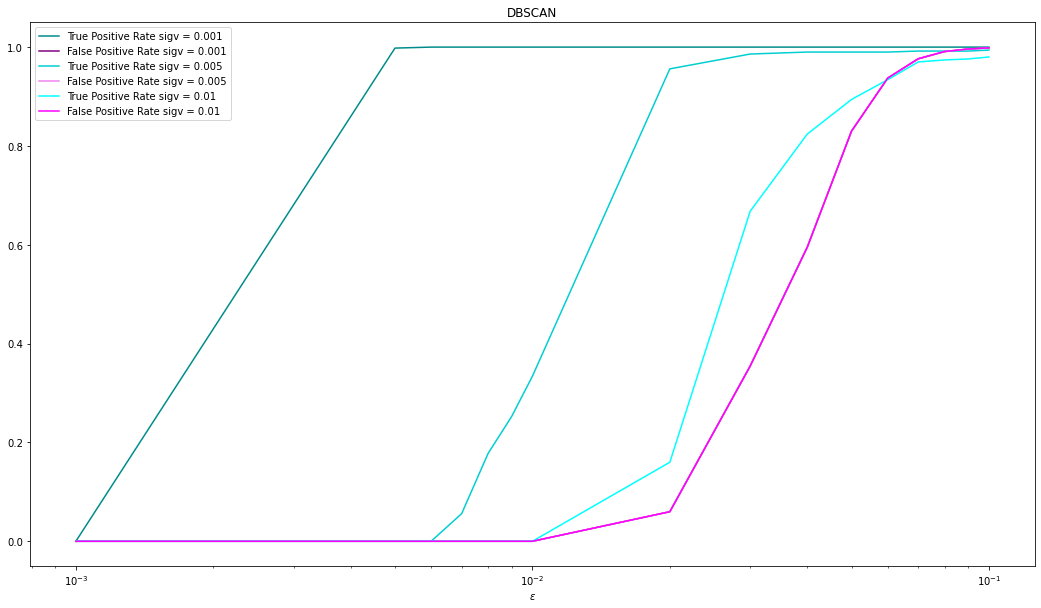

In [25]:
plt.subplots(figsize=(18,10))
plt.plot(DBstats[0,0,:], DBstats[0,1,:], 'darkcyan')
plt.plot(DBstats[0,0,:], DBstats[0,2,:], 'purple')
plt.plot(DBstats[1,0,:], DBstats[1,1,:], 'darkturquoise')
plt.plot(DBstats[1,0,:], DBstats[1,2,:], 'violet')
plt.plot(DBstats[2,0,:], DBstats[2,1,:], 'cyan')
plt.plot(DBstats[2,0,:], DBstats[2,2,:], 'magenta')
plt.xscale("log")
plt.legend(('True Positive Rate sigv = 0.001', 'False Positive Rate sigv = 0.001',
            'True Positive Rate sigv = 0.005', 'False Positive Rate sigv = 0.005',
            'True Positive Rate sigv = 0.01', 'False Positive Rate sigv = 0.01'))
plt.title('DBSCAN')
plt.xlabel(r'$\epsilon$');

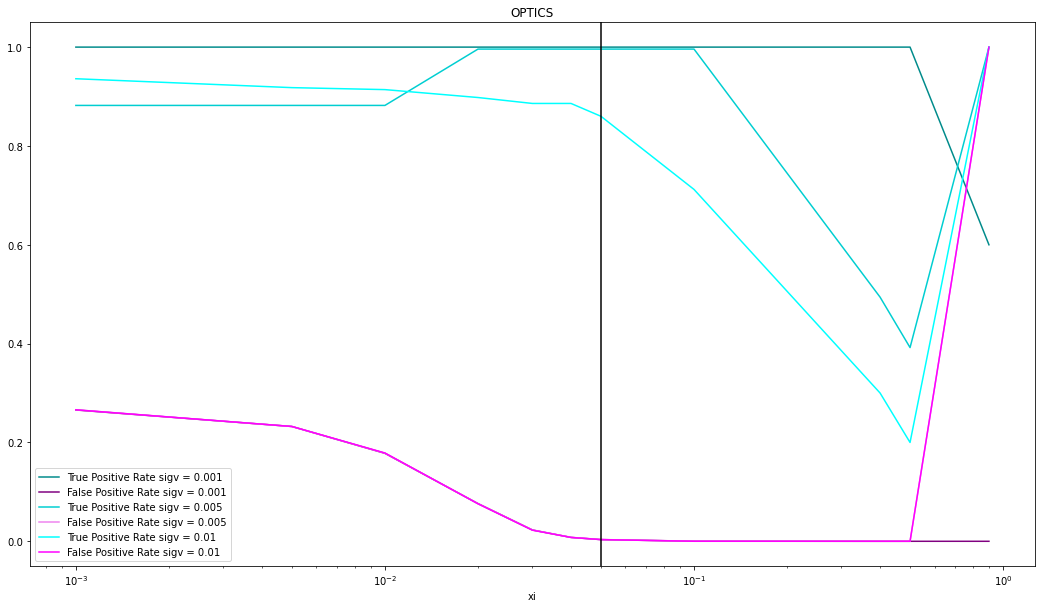

In [26]:
plt.subplots(figsize=(18,10))
plt.plot(OPTstats[0,0,:], OPTstats[0,1,:], 'darkcyan')
plt.plot(OPTstats[0,0,:], OPTstats[0,2,:], 'purple')
plt.plot(OPTstats[1,0,:], OPTstats[1,1,:], 'darkturquoise')
plt.plot(OPTstats[1,0,:], OPTstats[1,2,:], 'violet')
plt.plot(OPTstats[2,0,:], OPTstats[2,1,:], 'cyan')
plt.plot(OPTstats[2,0,:], OPTstats[2,2,:], 'magenta')
plt.axvline(x=0.05, ymin=0, ymax=1, c='k')

plt.xscale("log")
plt.legend(('True Positive Rate sigv = 0.001', 'False Positive Rate sigv = 0.001',
            'True Positive Rate sigv = 0.005', 'False Positive Rate sigv = 0.005',
            'True Positive Rate sigv = 0.01', 'False Positive Rate sigv = 0.01'))
plt.title('OPTICS')
plt.xlabel('xi');

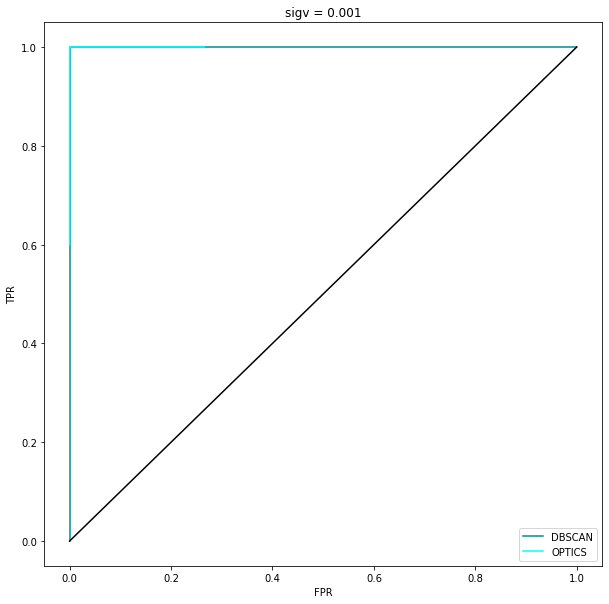

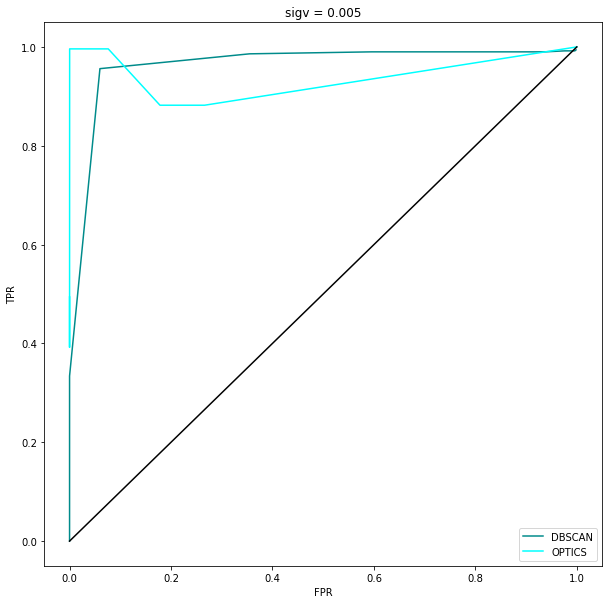

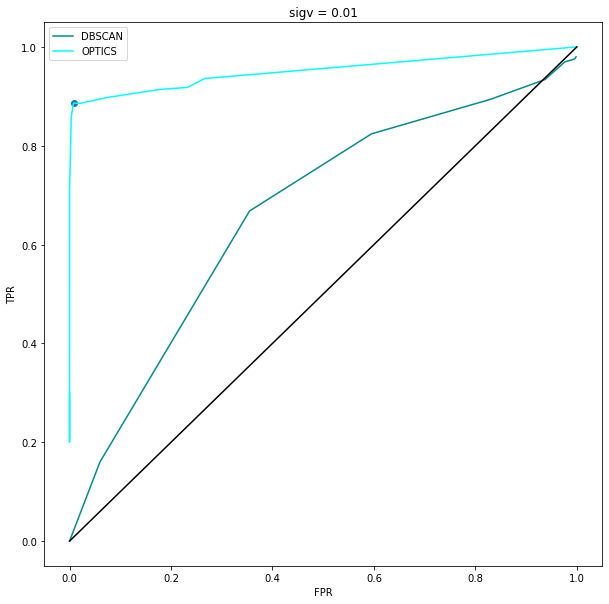

In [47]:
plt.subplots(figsize=(10,10))
idx1 = np.argsort(DBstats[0,2,:])
idx2 = np.argsort(OPTstats[0,2,:])
plt.plot(DBstats[0,2,:][idx1], DBstats[0,1,:][idx1], 'darkcyan') 
plt.plot(OPTstats[0,2,:][idx2], OPTstats[0,1,:][idx2], 'cyan')
plt.plot([0,1],[0,1], 'k')
plt.legend(('DBSCAN',
            'OPTICS'))
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.title('sigv = 0.001')
plt.show();

plt.subplots(figsize=(10,10))
idx1 = np.argsort(DBstats[1,2,:])
idx2 = np.argsort(OPTstats[1,2,:])
plt.plot(DBstats[1,2,:][idx1], DBstats[1,1,:][idx1], 'darkcyan') 
plt.plot(OPTstats[1,2,:][idx2], OPTstats[1,1,:][idx2], 'cyan') 
plt.plot([0,1],[0,1], 'k')
plt.legend(('DBSCAN',
            'OPTICS'))
plt.xlabel('FPR');
plt.ylabel('TPR');
plt.title('sigv = 0.005')
plt.show();

plt.subplots(figsize=(10,10))
idx1 = np.argsort(DBstats[2,2,:])
idx2 = np.argsort(OPTstats[2,2,:])
plt.plot(DBstats[2,2,:][idx1], DBstats[2,1,:][idx1], 'darkcyan') 
plt.plot(OPTstats[2,2,:][idx2], OPTstats[2,1,:][idx2], 'cyan')
plt.scatter(OPTstats[2,2,:][5], OPTstats[2,1,:][5])
plt.plot([0,1],[0,1], 'k')
plt.legend(('DBSCAN',
            'OPTICS'))
plt.title('sigv = 0.01')
plt.xlabel('FPR');
plt.ylabel('TPR');

In [51]:
OPTstats[2,:,5]  # xi,TPR,FPR of dot

array([0.04      , 0.886     , 0.00785873])